In [1]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('현재 가상환경 GPU 사용 가능상태')
else:
    device = 'cpu'
    print('GPU 사용 불가능 상태')

현재 가상환경 GPU 사용 가능상태


## MNIST 데이터 다운로드 & 전처리

In [2]:
maximum_epoch = 50
learning_rate = 0.001

import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Normalize

mnist_transform = transforms.Compose([transforms.RandomRotation(10),
                                transforms.RandomCrop(28, padding=2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

from torchvision import datasets
train_data = datasets.MNIST(root = './', train = True, download = True, transform = mnist_transform)

from torch.utils.data import random_split
train_data, valid_data = random_split(train_data, [54000,6000])
test_data = datasets.MNIST(root = './', train = False, download = True, transform = mnist_transform)

from torch.utils.data import DataLoader
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
def seed(seed = 1234):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed() # 시드 고정

## 모델 선언

In [4]:
# 필요한 import 구문
import torch.nn as nn
from torch.optim import Adam
from torchsummary import summary as Summary
import matplotlib.pyplot as plt
from torch.optim import Adam
import gc
from torch.cuda import memory_allocated, empty_cache
import numpy as np
from IPython.display import clear_output
import time
import seaborn as sns # 시각화 라이브러리
from sklearn.metrics import confusion_matrix
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import OneCycleLR

In [5]:
maximum_epoch = 30
learning_rate = 0.001

def init_model():
    global net, loss_fn, optim, scheduler
    net = My_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optim, mode='max', factor=0.5, patience=2, verbose=True, threshold=0.001, cooldown=1, min_lr=1e-6)

class My_model(nn.Module):
    def __init__(self):
        super(My_model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(3*3*128, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.BatchNorm2d = nn.BatchNorm2d(32)
        self.BatchNorm2d2 = nn.BatchNorm2d(64)
        self.BatchNorm2d3 = nn.BatchNorm2d(128) 
        self.BatchNorm1d = nn.BatchNorm1d(512)
        self.BatchNorm1d2 = nn.BatchNorm1d(10)

        # 가중치 초기화
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.BatchNorm2d(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.BatchNorm2d2(x)
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.BatchNorm2d3(x)
        conv_out = self.pool(x)
        x = self.dropout1(conv_out)
        x = x.view(-1, 3*3*128)
        x = self.relu(self.fc1(x))
        x = self.BatchNorm1d(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x, conv_out

# Model structure check
Summary(My_model().to(device),(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 14, 14]          18,496
              ReLU-6           [-1, 64, 14, 14]               0
       BatchNorm2d-7           [-1, 64, 14, 14]             128
         MaxPool2d-8             [-1, 64, 7, 7]               0
            Conv2d-9            [-1, 128, 7, 7]          73,856
             ReLU-10            [-1, 128, 7, 7]               0
      BatchNorm2d-11            [-1, 128, 7, 7]             256
        MaxPool2d-12            [-1, 128, 3, 3]               0
        Dropout2d-13            [-1, 128, 3, 3]               0
           Linear-14                  [

## 학습에 사용되는 함수
 - 초기화
 - 모델 구동
 - 학습 추이

#### 초기화

In [6]:
# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0
    
def init_log():
    plt.rc('font', size = 10)
    # 모든 Log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

#### 모델 구동

In [7]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()
    
# 학습 알고리즘
import numpy as np
def epoch(data_loader, mode = 'train'):
    global epoch_cnt
    
    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed, last_out, last_label = [], [], False, None, None
    
    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.to(device)
        
        
        # 코딩타임 - 1분
        
        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            net.eval() # Dropout, BatchNorm 수행하지 않음
            
        ##########

        result, _ = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출
        
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
        
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기르 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
            
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록
            
        # 5. 컨퓨전 매트릭스 출력을 위해 기록
        last_out = out.cpu().detach() # 모든 Predict 기록
        last_label = _label # 모든 GT 기록
        
    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1
    
    clear_memory()
    
    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc), last_out, last_label

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

#### 학습 추이

In [8]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)
    
def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력
    
    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)
    
    log_str = 'Epoch: {:3} | T_Loss {:5} | T_acc {:5} | V_Loss {:5} | V_acc. {:5} | \
🕒 {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)
    
    log_stack.append(log_str) # 프린트 준비
    
    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

### Early Stoppoing

In [9]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience = 10, verbose = False, delta = 0, path = 'checkpoint.pth', save = False):
#         patience (int): validation loss가 개선된 후 기다리는 기간
#         verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
#         delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
#         path (str): checkpoint저장 경로

        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.save = save

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print('EarlyStopping counter: {} out of {}'.format(self.counter, self.patience))
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # validation loss가 감소하면 모델을 저장한다.
        if self.verbose:
            print('Validation loss decresed ({:5} --> {:5}). Saving Model...'.format(self.val_loss_min, val_loss))
        if self.save == True:
            torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [10]:
def calculate_norm(dataset):
    # dataset의 axis=1, 2에 대한 평균 산출
    mean_ = np.array([np.mean(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 평균 산출
    mean_r = mean_[:, 0].mean()
    mean_g = mean_[:, 1].mean()
    mean_b = mean_[:, 2].mean()

    # dataset의 axis=1, 2에 대한 표준편차 산출
    std_ = np.array([np.std(x.numpy(), axis=(1, 2)) for x, _ in dataset])
    # r, g, b 채널에 대한 각각의 표준편차 산출
    std_r = std_[:, 0].mean()
    std_g = std_[:, 1].mean()
    std_b = std_[:, 2].mean()
    
    return (mean_r, mean_g, mean_b), (std_r, std_g, std_b)

## 모델 학습

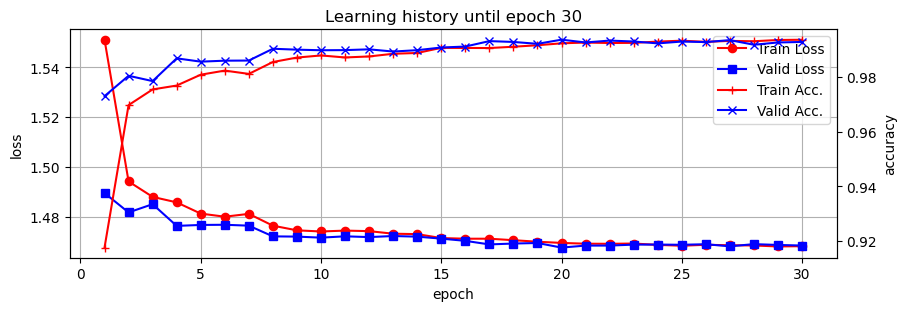

Epoch:  30 | T_Loss 1.468 | T_acc 0.994 | V_Loss 1.468 | V_acc. 0.993 | 🕒 17.59
Epoch:  29 | T_Loss 1.468 | T_acc 0.994 | V_Loss 1.469 | V_acc. 0.993 | 🕒 17.612
Epoch:  28 | T_Loss 1.468 | T_acc 0.993 | V_Loss 1.469 | V_acc. 0.992 | 🕒 18.048
Epoch:  27 | T_Loss 1.468 | T_acc 0.993 | V_Loss 1.468 | V_acc. 0.994 | 🕒 17.452
Epoch:  26 | T_Loss 1.469 | T_acc 0.993 | V_Loss 1.469 | V_acc. 0.993 | 🕒 18.513
Epoch:  25 | T_Loss 1.468 | T_acc 0.993 | V_Loss 1.469 | V_acc. 0.993 | 🕒 17.849
Epoch:  24 | T_Loss 1.469 | T_acc 0.993 | V_Loss 1.469 | V_acc. 0.992 | 🕒 18.333
Epoch:  23 | T_Loss 1.469 | T_acc 0.993 | V_Loss 1.469 | V_acc. 0.993 | 🕒 18.123
Epoch:  22 | T_Loss 1.469 | T_acc 0.992 | V_Loss 1.468 | V_acc. 0.993 | 🕒 18.103
Epoch:  21 | T_Loss 1.469 | T_acc 0.993 | V_Loss 1.468 | V_acc. 0.993 | 🕒 18.159
Epoch:  20 | T_Loss 1.469 | T_acc 0.992 | V_Loss 1.468 | V_acc. 0.994 | 🕒 17.974
Epoch:  19 | T_Loss  1.47 | T_acc 0.992 | V_Loss 1.469 | V_acc. 0.992 | 🕒 18.372
Epoch:  18 | T_Loss  1.47 | T

In [11]:
seed() # 시드 고정
# Training Initialization
init_model()
init_epoch()
init_log()
early_stopping = EarlyStopping(patience = 10)

best_test_acc, best_epoch = 0, 0
# Training Iteration
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc, _, _ = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc, _, _ = epoch(valid_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    
    # early_stopping는 validation loss가 감소하였는지 확인
    early_stopping(vloss, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    with torch.no_grad():
        net.eval()
        _, test_acc, _, _ = epoch(test_loader, mode = 'test')
        
        # Test 점수가 가장 좋았던 모델을 저장한다
        if best_test_acc < test_acc:
            best_test_acc = test_acc
            best_epoch = epoch_cnt
            print('Epoch: {} / Test Acc: {} | 최고 점수가 갱신되었습니다. 모델 중간 저장을 시행합니다.'.format(best_epoch, round(best_test_acc, 5)))
            torch.save(net.state_dict(), './model.pth')
    
    # 학습률 스케줄링
    scheduler.step(test_acc)

print('\n Training completed!')

## 모델 정확도

In [12]:
net = My_model().to(device)
net.load_state_dict(torch.load('./model.pth'))

# 정확도 검증
with torch.no_grad():
    test_loss, test_acc, test_out, test_label = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

print('저장된 Best Model: Epoch: {}/ Test Accuracy: {}'.format(best_epoch, round(best_test_acc, 4)))

Test Acc.: 0.9951
Test Loss: 1.4665
저장된 Best Model: Epoch: 24/ Test Accuracy: 0.9952


## 결과 분석

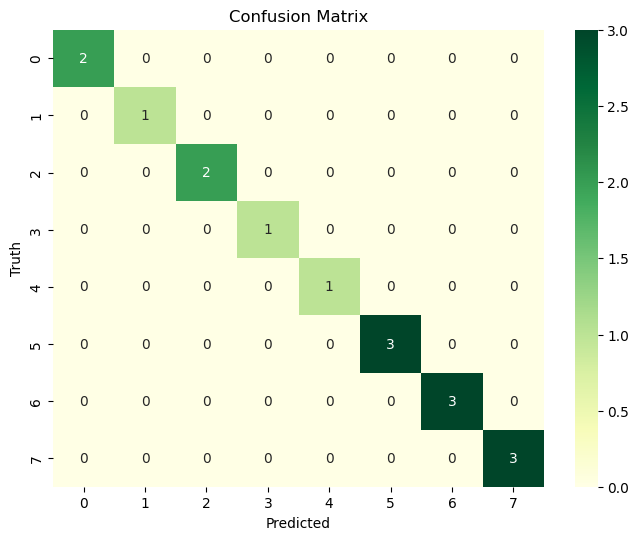

In [13]:
# Confusion matrix
our_cmatrix = confusion_matrix(test_label, test_out)
plt.figure(figsize=(8, 6), dpi=99)
sns.heatmap(our_cmatrix, annot=True, fmt='g', cmap='YlGn').set(xlabel='Predicted', ylabel='Truth')
plt.title('Confusion Matrix')
plt.show()


##########

In [14]:
def check_error(wrong_loader, Number_Of_Error):
    cnt = 0
    for _data, _y in wrong_loader: # 데이터에서 사진과 라벨을 분리
    
        # 코딩타임 ( 데이터를 모델에 넣고 예측 결과 1, 2, 3 순위 출력 ) - 3 분
        
        data, _y = _data.to(device), _y.to(device) # data, label 을 gpu 에서 처리할 수 있도록 처리
        results, _ = net(data) # 모델에 데이터를 넣고 모든 class 에 대한 확률값인 results 를 반환
        _, pred_y = torch.max(results, 1) # result 에서 최대 확률값을 기준으로 예측 class 도출

        if _y != pred_y :
            print('real_label : {}, predict_label : {}'.format(_y, pred_y))
            _data = torch.squeeze(_data)
            plt.figure(figsize=(3,3))
            plt.imshow(_data, cmap='gray')
            plt.show()
            cnt +=1
        if cnt >= Number_Of_Error :
            break

real_label : tensor([9], device='cuda:0'), predict_label : tensor([4], device='cuda:0')


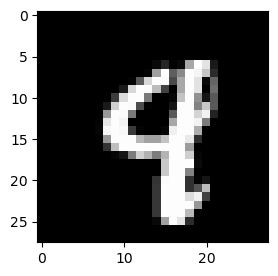

real_label : tensor([7], device='cuda:0'), predict_label : tensor([3], device='cuda:0')


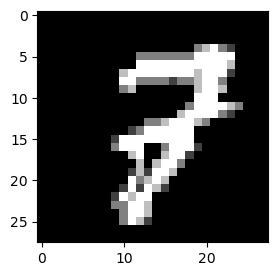

real_label : tensor([8], device='cuda:0'), predict_label : tensor([2], device='cuda:0')


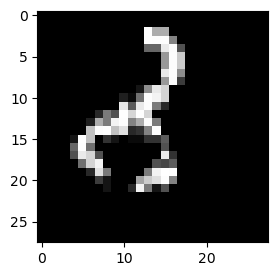

real_label : tensor([2], device='cuda:0'), predict_label : tensor([7], device='cuda:0')


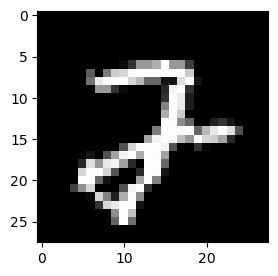

real_label : tensor([6], device='cuda:0'), predict_label : tensor([4], device='cuda:0')


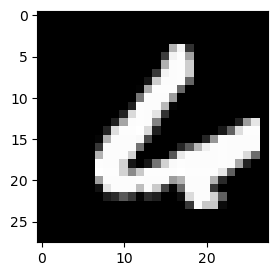

: 

In [15]:
# 코딩타임 (test 용 데이터 로더를 만들고 , 함수를 run)
wrong_loader = DataLoader(test_data, pin_memory=True) # batch size 없이 통채로 데이터 로더에 test 데이터 삽입
check_error(wrong_loader, 5)
##########